In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# =============================================================================
# Hamiltonian Mechanics for Satellite Constellation Optimization
# =============================================================================


In [3]:
class HamiltonianConstellationOptimizer:
    """
    Optimize satellite constellations using Hamiltonian mechanics.
    Satellites evolve naturally toward optimal coverage configurations.
    """
    
    def __init__(self, n_satellites=3):
        self.n_satellites = n_satellites
        self.earth_radius = 6371.0  # km
        
    def great_circle_distance(self, lat1, lon1, lat2, lon2):
        """Calculate great circle distance between two points"""
        lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
        lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
        
        x1 = np.cos(lat1_rad) * np.cos(lon1_rad)
        y1 = np.cos(lat1_rad) * np.sin(lon1_rad)
        z1 = np.sin(lat1_rad)
        
        x2 = np.cos(lat2_rad) * np.cos(lon2_rad)
        y2 = np.cos(lat2_rad) * np.sin(lon2_rad)
        z2 = np.sin(lat2_rad)
        
        dot_product = x1*x2 + y1*y2 + z1*z2
        angular_distance = np.arccos(np.clip(dot_product, -1, 1))
        
        return angular_distance
    
    def spherical_coverage_overlap(self, lat1, lon1, lat2, lon2):
        """Calculate coverage overlap using cos(angular_distance/2)"""
        angular_distance = self.great_circle_distance(lat1, lon1, lat2, lon2)
        overlap = np.cos(angular_distance / 2)
        return max(0, overlap)
    
    def coverage_matrix_3d(self, positions):
        """Build coverage matrix for N satellites"""
        n = len(positions)
        C = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    C[i,j] = 1.0
                else:
                    lat1, lon1 = positions[i]
                    lat2, lon2 = positions[j]
                    C[i,j] = self.spherical_coverage_overlap(lat1, lon1, lat2, lon2)
        
        return C
    
    def coverage_potential(self, positions):
        """
        Potential energy function based on coverage quality.
        Lower potential = better coverage (system naturally minimizes).
        """
        C = self.coverage_matrix_3d(positions)
        eigenvals = np.linalg.eigvals(C)
        
        # Convert eigenvalue maximization to potential minimization
        min_eigenval = np.min(eigenvals)
        
        # Add penalty for satellites getting too close (numerical stability)
        penalty = 0
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                dist = self.great_circle_distance(positions[i][0], positions[i][1],
                                                positions[j][0], positions[j][1])
                if dist < 0.1:  # Penalty if closer than ~6° separation
                    penalty += 10 * (0.1 - dist)**2
        
        # Potential energy (negative because we want to maximize eigenvalue)
        V = -min_eigenval + penalty
        return V
    
    def numerical_gradient(self, positions, h=1e-6):
        """
        Calculate numerical gradient of potential energy.
        This gives the forces acting on each satellite.
        """
        n_sats = len(positions)
        grad = np.zeros((n_sats, 2))
        
        base_potential = self.coverage_potential(positions)
        
        for i in range(n_sats):
            for j in range(2):  # lat, lon
                # Forward difference
                pos_forward = [list(pos) for pos in positions]
                pos_forward[i][j] += h
                potential_forward = self.coverage_potential(pos_forward)
                
                # Gradient component
                grad[i,j] = (potential_forward - base_potential) / h
        
        return grad
    
    def hamiltonian_dynamics(self, t, state):
        """
        Hamilton's equations of motion for the satellite system.
        state = [lat1, lon1, lat2, lon2, lat3, lon3, p_lat1, p_lon1, p_lat2, p_lon2, p_lat3, p_lon3]
        """
        n = self.n_satellites
        
        # Split state into positions and momenta
        positions = []
        momenta = []
        
        for i in range(n):
            positions.append([state[2*i], state[2*i+1]])
            momenta.append([state[2*n + 2*i], state[2*n + 2*i+1]])
        
        # Calculate gradient of potential (forces)
        grad_V = self.numerical_gradient(positions)
        
        # Hamilton's equations: dq/dt = ∂H/∂p, dp/dt = -∂H/∂q
        state_dot = np.zeros_like(state)
        
        for i in range(n):
            # Position evolution: dq/dt = p (kinetic energy term)
            state_dot[2*i] = momenta[i][0]      # d(lat)/dt = p_lat
            state_dot[2*i+1] = momenta[i][1]    # d(lon)/dt = p_lon
            
            # Momentum evolution: dp/dt = -∂V/∂q (potential energy gradient)
            state_dot[2*n + 2*i] = -grad_V[i,0]     # dp_lat/dt = -∂V/∂lat
            state_dot[2*n + 2*i+1] = -grad_V[i,1]   # dp_lon/dt = -∂V/∂lon
        
        return state_dot
    
    def total_energy(self, state):
        """Calculate total Hamiltonian (kinetic + potential energy)"""
        n = self.n_satellites
        
        # Extract positions and momenta
        positions = []
        momenta = []
        
        for i in range(n):
            positions.append([state[2*i], state[2*i+1]])
            momenta.append([state[2*n + 2*i], state[2*n + 2*i+1]])
        
        # Kinetic energy: ½Σp²
        kinetic = 0.5 * np.sum([p[0]**2 + p[1]**2 for p in momenta])
        
        # Potential energy
        potential = self.coverage_potential(positions)
        
        return kinetic + potential
    
    def optimize_constellation(self, initial_positions, t_max=50, n_steps=5000):
        """
        Optimize constellation using Hamiltonian evolution.
        
        Parameters:
        - initial_positions: Starting satellite positions [(lat,lon), ...]
        - t_max: Maximum evolution time
        - n_steps: Number of integration steps
        
        Returns:
        - solution: Full trajectory of the system
        - final_positions: Optimized satellite positions
        """
        
        # Initial state: positions + small random momenta
        initial_state = []
        
        # Add positions
        for pos in initial_positions:
            initial_state.extend(pos)
        
        # Add small random initial momenta (like thermal motion)
        for _ in range(self.n_satellites):
            initial_state.extend([np.random.normal(0, 0.1), np.random.normal(0, 0.1)])
        
        initial_state = np.array(initial_state)
        
        print(f"🚀 Starting Hamiltonian evolution...")
        print(f"Initial energy: {self.total_energy(initial_state):.6f}")
        
        # Solve Hamilton's equations
        t_span = (0, t_max)
        t_eval = np.linspace(0, t_max, n_steps)
        
        solution = solve_ivp(
            self.hamiltonian_dynamics, 
            t_span, 
            initial_state, 
            t_eval=t_eval,
            method='DOP853',  # High-precision integrator
            rtol=1e-8
        )
        
        # Extract final positions
        final_state = solution.y[:, -1]
        final_positions = []
        for i in range(self.n_satellites):
            final_positions.append([final_state[2*i], final_state[2*i+1]])
        
        print(f"Final energy: {self.total_energy(final_state):.6f}")
        print(f"Energy conservation error: {abs(self.total_energy(final_state) - self.total_energy(initial_state)):.8f}")
        
        return solution, final_positions
    
    def plot_evolution(self, solution, title="Hamiltonian Constellation Evolution"):
        """Visualize the satellite evolution process"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Extract trajectories
        n = self.n_satellites
        time = solution.t
        
        positions_history = []
        momenta_history = []
        
        for i in range(n):
            lat_traj = solution.y[2*i, :]
            lon_traj = solution.y[2*i+1, :]
            p_lat_traj = solution.y[2*n + 2*i, :]
            p_lon_traj = solution.y[2*n + 2*i+1, :]
            
            positions_history.append([lat_traj, lon_traj])
            momenta_history.append([p_lat_traj, p_lon_traj])
        
        # Plot 1: Satellite trajectories on Earth
        ax1 = axes[0,0]
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for i in range(n):
            lat_traj, lon_traj = positions_history[i]
            color = colors[i % len(colors)]
            ax1.plot(lon_traj, lat_traj, color=color, alpha=0.7, linewidth=2, 
                    label=f'Satellite {i+1}')
            ax1.scatter(lon_traj[0], lat_traj[0], color=color, s=100, marker='o', 
                       edgecolor='black', label=f'Start {i+1}')
            ax1.scatter(lon_traj[-1], lat_traj[-1], color=color, s=100, marker='*', 
                       edgecolor='black', label=f'Final {i+1}')
        
        ax1.set_xlim(-180, 180)
        ax1.set_ylim(-90, 90)
        ax1.set_xlabel('Longitude (degrees)')
        ax1.set_ylabel('Latitude (degrees)')
        ax1.set_title('Satellite Trajectories on Earth')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Energy conservation
        ax2 = axes[0,1]
        energies = [self.total_energy(solution.y[:, i]) for i in range(len(time))]
        ax2.plot(time, energies, 'purple', linewidth=2)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Total Energy (Hamiltonian)')
        ax2.set_title('Energy Conservation Check')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Coverage quality evolution
        ax3 = axes[1,0]
        coverage_qualities = []
        
        for i in range(0, len(time), 50):  # Sample every 50th point for efficiency
            positions = []
            for j in range(n):
                positions.append([solution.y[2*j, i], solution.y[2*j+1, i]])
            
            C = self.coverage_matrix_3d(positions)
            min_eigenval = np.min(np.linalg.eigvals(C))
            coverage_qualities.append(min_eigenval)
        
        sample_times = time[::50]
        ax3.plot(sample_times, coverage_qualities, 'green', linewidth=2)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Min Eigenvalue (Coverage Quality)')
        ax3.set_title('Coverage Optimization Progress')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Phase space (momentum vs position for first satellite)
        ax4 = axes[1,1]
        lat_traj, lon_traj = positions_history[0]
        p_lat_traj, p_lon_traj = momenta_history[0]
        
        # Color by time
        scatter = ax4.scatter(lat_traj, p_lat_traj, c=time, cmap='viridis', alpha=0.6)
        ax4.set_xlabel('Latitude (degrees)')
        ax4.set_ylabel('Momentum (p_lat)')
        ax4.set_title('Phase Space: Satellite 1')
        ax4.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax4, label='Time')
        
        plt.tight_layout()
        plt.show()
        
        # Print final results
        print("\n🛰️ HAMILTONIAN OPTIMIZATION RESULTS")
        print("="*50)
        
        # Calculate final coverage matrix
        final_positions = []
        final_state = solution.y[:, -1]
        for i in range(n):
            final_positions.append([final_state[2*i], final_state[2*i+1]])
        
        final_C = self.coverage_matrix_3d(final_positions)
        final_eigenvals = np.linalg.eigvals(final_C)
        
        print("Final satellite positions:")
        for i, pos in enumerate(final_positions):
            print(f"  Sat {i+1}: ({pos[0]:.2f}°N, {pos[1]:.2f}°E)")
        
        print(f"\nFinal coverage matrix eigenvalues: {np.sort(final_eigenvals)[::-1]}")
        print(f"Minimum eigenvalue (system performance): {np.min(final_eigenvals):.4f}")
        
        return final_positions, final_C


# =============================================================================
# Usage Example
# =============================================================================

🌪️ HAMILTONIAN CONSTELLATION OPTIMIZATION
Starting positions:
  Sat 1: (12°N, 14°E)
  Sat 2: (45°N, 54°E)
  Sat 3: (78°N, 98°E)

Initial min eigenvalue: 0.0149
🚀 Starting Hamiltonian evolution...
Initial energy: 0.017270
Final energy: 0.017270
Energy conservation error: 0.00000001


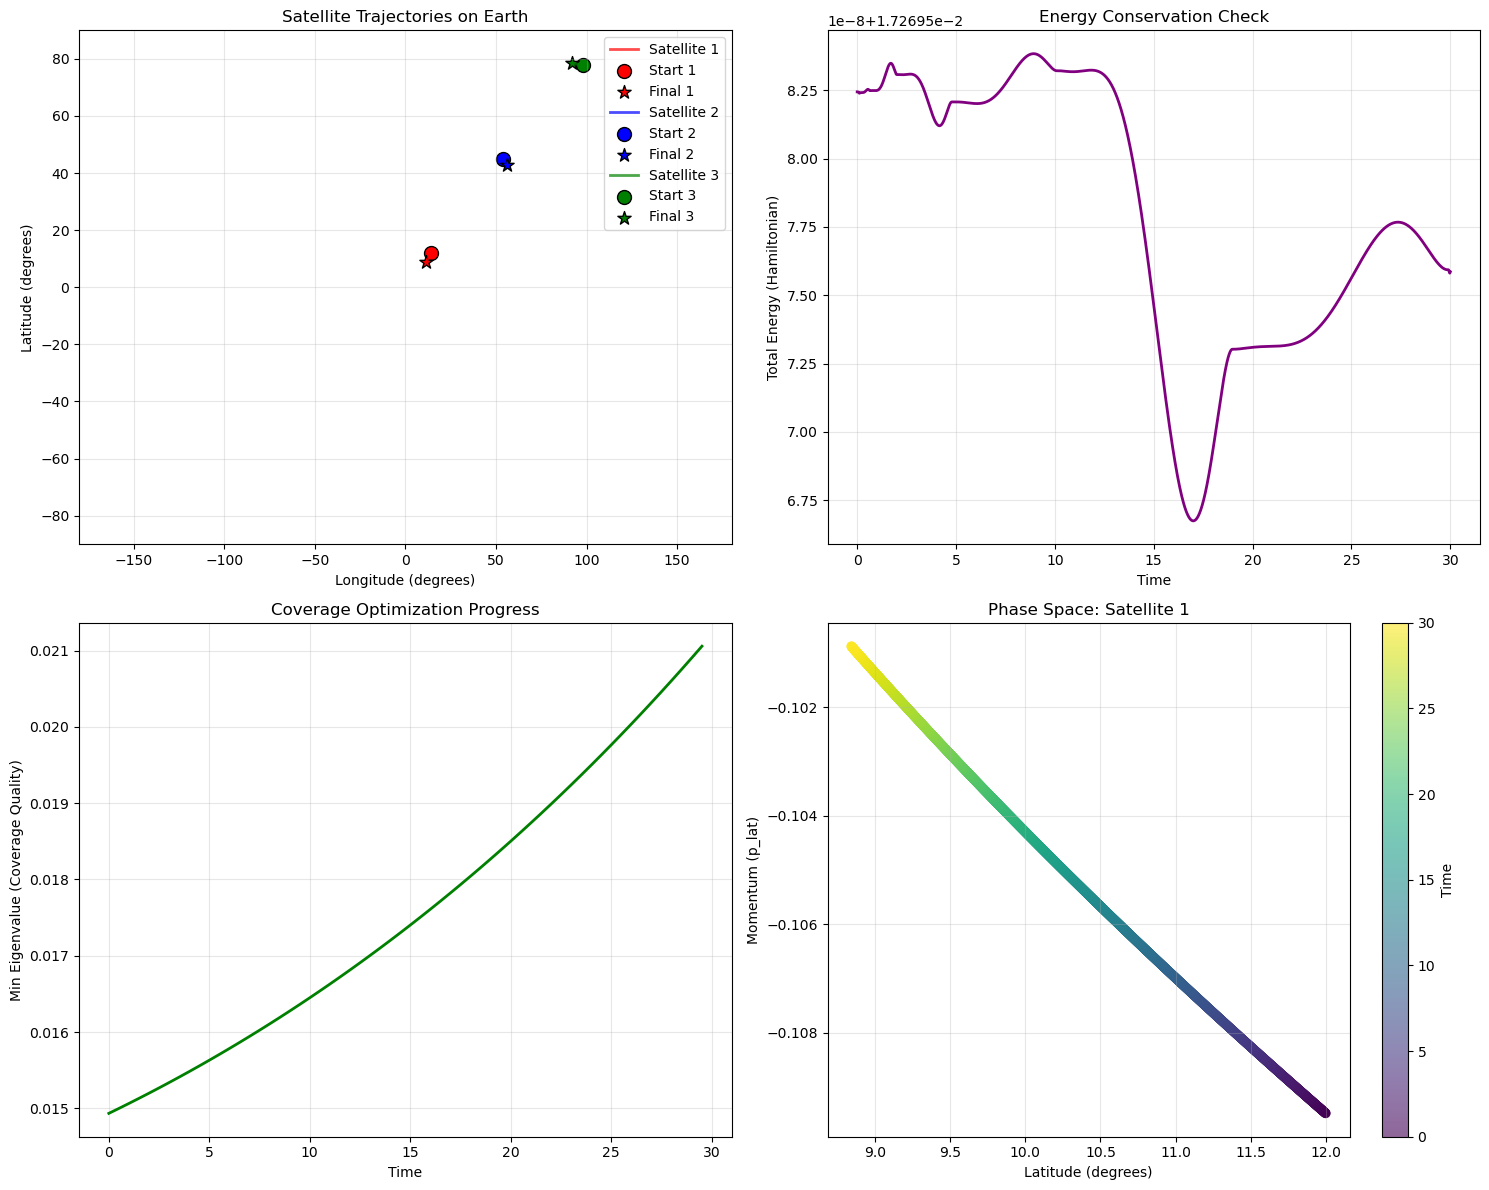


🛰️ HAMILTONIAN OPTIMIZATION RESULTS
Final satellite positions:
  Sat 1: (8.84°N, 11.51°E)
  Sat 2: (42.95°N, 55.88°E)
  Sat 3: (78.49°N, 91.81°E)

Final coverage matrix eigenvalues: [2.74525368 0.23353851 0.0212078 ]
Minimum eigenvalue (system performance): 0.0212


In [4]:
if __name__ == "__main__":
    # Create Hamiltonian optimizer
    optimizer = HamiltonianConstellationOptimizer(n_satellites=3)
    
    # Starting positions (your test case)
    initial_positions = [[12, 14], [45, 54], [78, 98]]
    
    print("🌪️ HAMILTONIAN CONSTELLATION OPTIMIZATION")
    print("="*50)
    print("Starting positions:")
    for i, pos in enumerate(initial_positions):
        print(f"  Sat {i+1}: ({pos[0]}°N, {pos[1]}°E)")
    
    # Initial coverage analysis
    initial_C = optimizer.coverage_matrix_3d(initial_positions)
    initial_eigenvals = np.linalg.eigvals(initial_C)
    print(f"\nInitial min eigenvalue: {np.min(initial_eigenvals):.4f}")
    
    # Run Hamiltonian optimization
    solution, final_positions = optimizer.optimize_constellation(
        initial_positions, 
        t_max=30,  # Evolution time
        n_steps=3000
    )
    
    # Visualize results
    optimizer.plot_evolution(solution)